<a href="https://colab.research.google.com/github/NahianAlindo/gait_recognition/blob/main/Model_with_GRU_blocks_TPU_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive and Accelerator status

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import os
try:
    tpu = False
    assert torch.cuda.is_available()
    gpu = True
    ! nvidia-smi
except:
    tpu = True
    gpu = False
    if 'COLAB_TPU_ADDR' not in os.environ:
        print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
    else:
        tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
        print ('TPU address is', tpu_address)
    import tensorflow as tf
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
    strategy = tf.distribute.TPUStrategy(resolver)

Tue Dec  7 05:51:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install keras_tuner

     |████████████████████████████████| 98 kB 3.1 MB/s 


# Import Libraries

In [ ]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
# import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.constraints import max_norm as maxnorm
import seaborn as sns
import tensorflow.keras.metrics as metrics
import tensorflow.keras as keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Utility Functions for loading dataset, plots and performance

In [ ]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [ ]:
def get_test_performance(model, X_test, test_label):
    score=model.evaluate(X_test,test_label,verbose=1)
    print(f'Test loss:{score[0]}')
    print(f'Test accuracy:{score[1]}')
    print(f'Test Recall: {score[3]}')
    print(f'Test AUC: {score[2]}')

In [ ]:
def plot_performance(X_train, train_label, history):
    plt.plot(history.history['accuracy'])
    try:
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
    except:
        pass
    try:
        plt.legend(['val'], loc='upper left')
    except:
        pass
    plt.show()

    plt.plot(history.history['loss'])
    try:
        plt.plot(history.history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    try:
        plt.legend(['val'], loc='upper left')
    except:
        pass
    plt.show()

In [ ]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# Tuner

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
def post_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = GRU(units=hp.Choice('GRU_1', values = [8,16,32,64,128,256,512]))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_1_filter_size', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_2_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512,]), hp.Choice(name='conv_3_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    # batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    if gpu:
        opt = keras.optimizers.Adam(learning_rate=0.001)
    if tpu:
        opt = keras.optimizers.Adam(learning_rate=8*0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

# Tune on 90% data

In [ ]:
if gpu:
    tuner = kt.tuners.BayesianOptimization(post_se,
        objective='val_accuracy',
        max_trials=30,
        seed=42,
        project_name='Model_gpu')
    # Will stop training if the "val_loss" hasn't improved in 30 epochs.
    tuner.search(X_train, train_label, epochs=200, validation_split=0.1, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

if tpu:
    print("TPU")
    with strategy.scope():
        tuner = kt.tuners.BayesianOptimization(post_se,
            objective='val_accuracy',
            max_trials=30,
            seed=42,
            project_name='Model_tpu')
        # Will stop training if the "val_loss" hasn't improved in 30 epochs.
        tuner.search(X_train, train_label, epochs=200, validation_split=0.1, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

Trial 7 Complete [00h 39m 46s]
val_accuracy: 0.99275141954422

Best val_accuracy So Far: 0.9972817897796631
Total elapsed time: 05h 56m 14s

Search: Running Trial #8

Hyperparameter    |Value             |Best Value So Far 
GRU_1             |512               |8                 
Dropout           |0.8               |0.8               
conv_1_filter     |32                |32                
conv_1_filter_size|9                 |9                 
conv_2_filter     |512               |256               
conv_2_filter_size|3                 |3                 
conv_3_filter     |512               |512               
conv_3_filter_size|8                 |3                 

Epoch 1/200
932/932 [==============================] - 61s 58ms/step - loss: 0.6379 - accuracy: 0.8495 - val_loss: 0.1801 - val_accuracy: 0.9562
Epoch 2/200
932/932 [==============================] - 53s 57ms/step - loss: 0.1560 - accuracy: 0.9587 - val_loss: 0.1305 - val_accuracy: 0.9610
Epoch 3/200
932/932 [========

# MODEL DEFINITION

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = GRU(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(32, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

# Train on 90% data Dataset 1

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 32)      1760        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                   

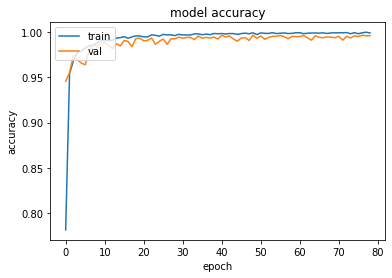

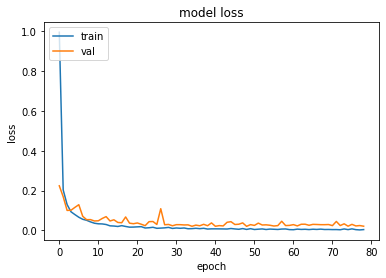

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 2s 15ms/step - loss: 0.6091 - accuracy: 0.9465 - auc: 0.9822 - recall: 0.9463
Test loss:0.6091221570968628
Test accuracy:0.9465240836143494
Test Recall: 0.946256697177887
Test AUC: 0.9822481870651245


# Train Full Manually Dataset 1

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 32)      1760        ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 32)     128         ['conv1d_6[0][0]']               
 rmalization)                                                                               

KeyError: ignored

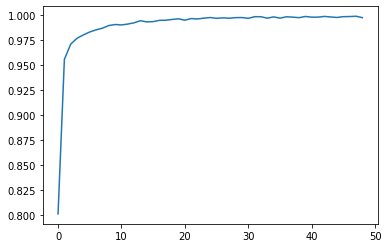

In [ ]:
epochs = 49
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

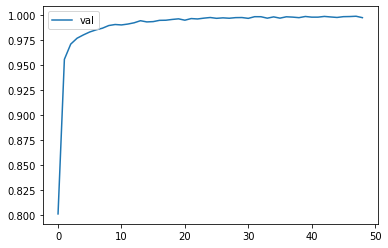

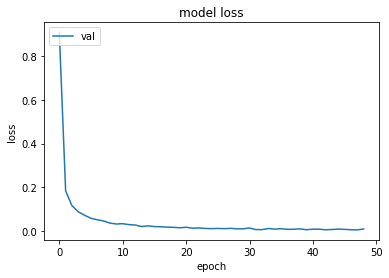

In [ ]:
plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 4s 15ms/step - loss: 0.5415 - accuracy: 0.9430 - auc: 0.9801 - recall: 0.9422
Test loss:0.5414764881134033
Test accuracy:0.9430481195449829
Test Recall: 0.9422459602355957
Test AUC: 0.9801108241081238


# Train 90%  Dataset 2

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 32)      1760        ['permute_3[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 32)     128         ['conv1d_9[0][0]']               
 rmalization)                                                                               

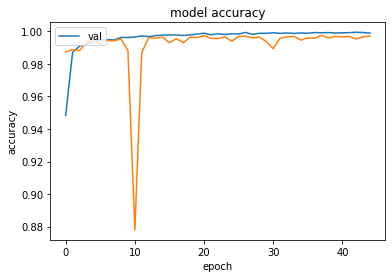

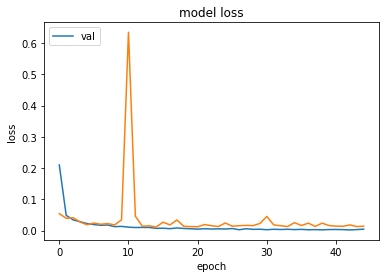

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 2s 16ms/step - loss: 0.2805 - accuracy: 0.9753 - auc: 0.9899 - recall: 0.9751
Test loss:0.28054672479629517
Test accuracy:0.9752836227416992
Test Recall: 0.9750810265541077
Test AUC: 0.9898920059204102


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


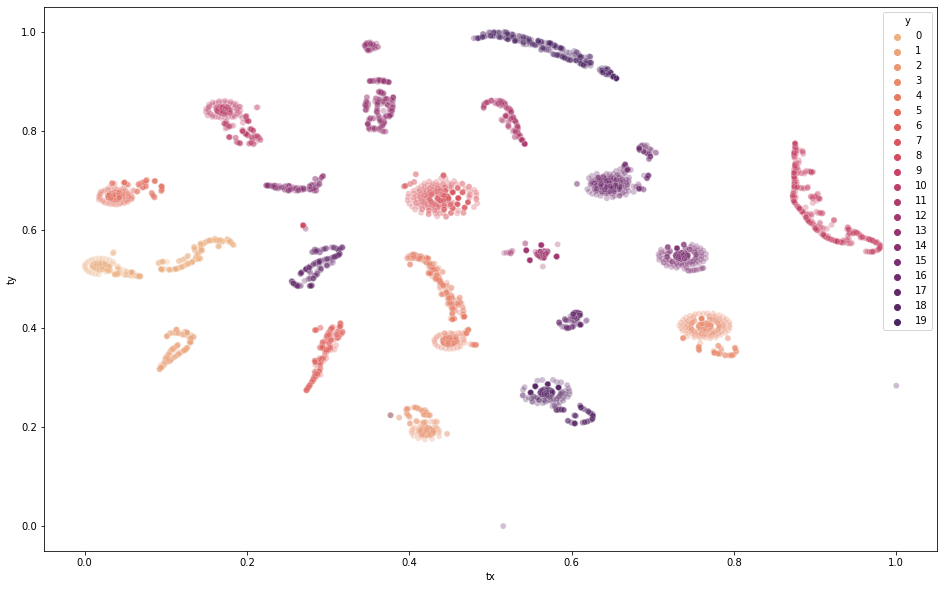

In [ ]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
features = model.predict(X_test)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features)
import pandas as pd
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))

    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
tx = list(tx)
ty = list(ty)

data = {'tx':tx,
        'ty':ty}
df = pd.DataFrame(data)
df['y'] = y_classes
# fig = plt.figure()

# ax = fig.add_subplot(111)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tx", y="ty",
    hue="y",
    palette=sns.color_palette("flare", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

# Train Full Manually Dataset 2

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_4 (Permute)            (None, 128, 6)       0           ['input_5[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 128, 32)      1760        ['permute_4[0][0]']              
                                                                                                  
 batch_normalization_12 (BatchN  (None, 128, 32)     128         ['conv1d_12[0][0]']              
 ormalization)                                                                              

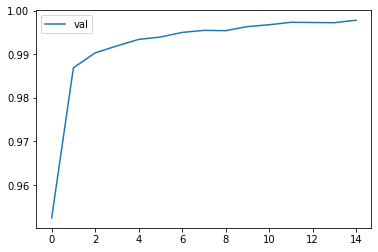

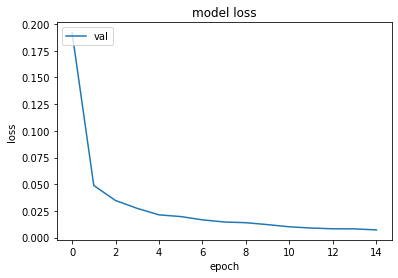

In [ ]:
epochs = 15
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 4s 15ms/step - loss: 0.1760 - accuracy: 0.9755 - auc: 0.9909 - recall: 0.9745
Test loss:0.17602291703224182
Test accuracy:0.9754862189292908
Test Recall: 0.974473237991333
Test AUC: 0.9909349679946899


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


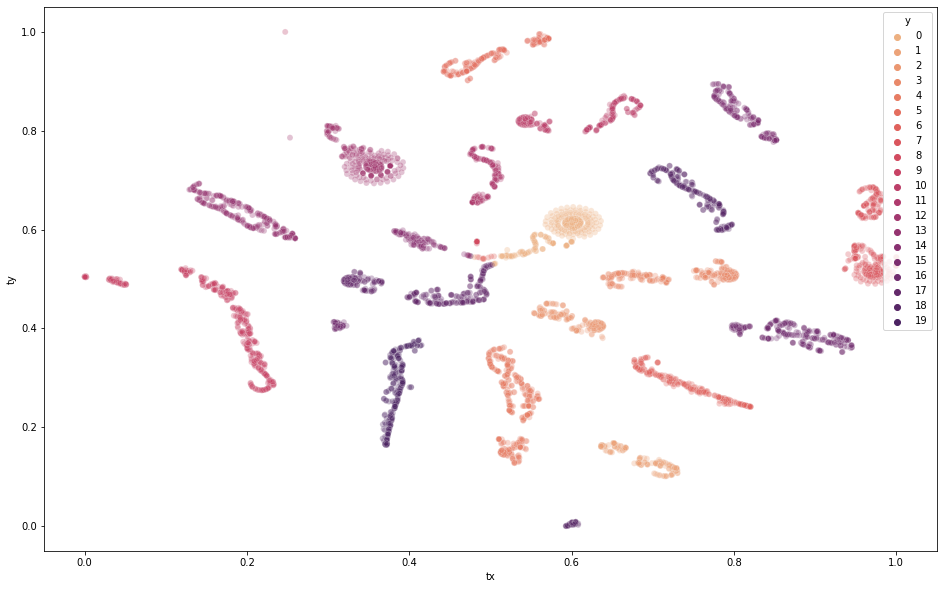

In [ ]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
features = model.predict(X_test)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features)
import pandas as pd
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))

    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
tx = list(tx)
ty = list(ty)

data = {'tx':tx,
        'ty':ty}
df = pd.DataFrame(data)
df['y'] = y_classes
# fig = plt.figure()

# ax = fig.add_subplot(111)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tx", y="ty",
    hue="y",
    palette=sns.color_palette("flare", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

# Train 90%  Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 32)      1760        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 32)     128         ['conv1d[0][0]']                 
 alization)                                              

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 32)      1760        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 32)     128         ['conv1d_3[0][0]']               
 rmalization)                                                                               

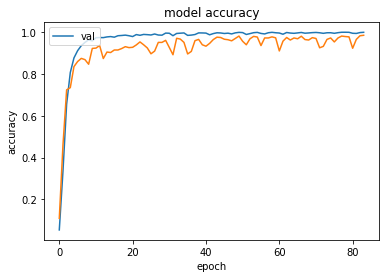

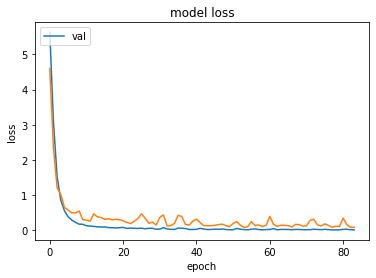

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 17ms/step - loss: 0.1582 - accuracy: 0.9666 - auc: 0.9954 - recall: 0.9617
Test loss:0.15817959606647491
Test accuracy:0.9666430354118347
Test Recall: 0.9616749286651611
Test AUC: 0.9953796863555908


# Train Full Manually Dataset OU-ISIR

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 32)      1760        ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 32)     128         ['conv1d_6[0][0]']               
 rmalization)                                                                               

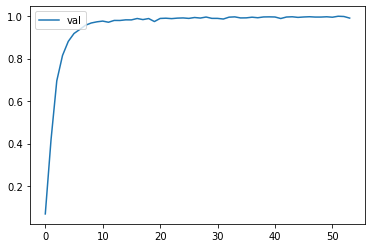

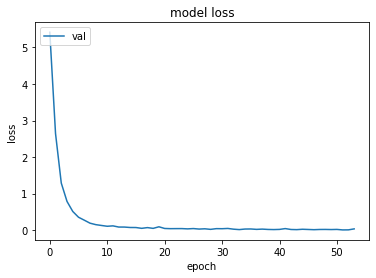

In [ ]:
epochs = 54
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 3s 18ms/step - loss: 0.2537 - accuracy: 0.9475 - auc: 0.9943 - recall: 0.9432
Test loss:0.2536563575267792
Test accuracy:0.9474804997444153
Test Recall: 0.943222165107727
Test AUC: 0.9943027496337891


# Tune Test = val 

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
def post_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = GRU(units=hp.Choice('gru_1', values = [8,16,32,64,128,256,512]))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    # x = GRU(units=hp.Choice('gru_2', values = [8,16,32,64,128,256,512]))(x)
    # x = Dropout(hp.Choice(name='Dropout_2', values = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Choice('conv_1_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_1_filter_size', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_2_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_2_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Choice('conv_3_filter', values = [32,64,128,256,512]), hp.Choice(name='conv_3_filter_size',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    # batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512, 1024, 2048, 4096])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    if gpu:
        opt = keras.optimizers.Adam(learning_rate=0.001)
    if tpu:
        opt = keras.optimizers.Adam(learning_rate=8*0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

In [ ]:
if gpu:
    tuner = kt.tuners.BayesianOptimization(post_se,
        objective='val_accuracy',
        max_trials=30,
        seed=42,
        project_name='Model_gpu')
    # Will stop training if the "val_loss" hasn't improved in 30 epochs.
    tuner.search(X_train, train_label, epochs=200, validation_data=(X_test,test_label), shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

if tpu:
    with strategy.scope():
        tuner = kt.tuners.BayesianOptimization(post_se,
            objective='val_accuracy',
            max_trials=30,
            seed=42,
            project_name='Model_tpu_test')
        # Will stop training if the "val_loss" hasn't improved in 30 epochs.
        tuner.search(X_train, train_label, epochs=200, validation_data=(X_test,test_label), shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)])

Trial 12 Complete [00h 16m 46s]
val_accuracy: 0.9344919919967651

Best val_accuracy So Far: 0.9513369202613831
Total elapsed time: 05h 19m 32s

Search: Running Trial #13

Hyperparameter    |Value             |Best Value So Far 
gru_1             |8                 |8                 
Dropout           |0.8               |0.8               
conv_1_filter     |32                |32                
conv_1_filter_size|3                 |9                 
conv_2_filter     |512               |256               
conv_2_filter_size|9                 |3                 
conv_3_filter     |512               |512               
conv_3_filter_size|9                 |3                 

Epoch 1/200
1035/1035 [==============================] - 67s 59ms/step - loss: 0.6512 - accuracy: 0.8551 - val_loss: 0.6732 - val_accuracy: 0.8479
Epoch 2/200
1035/1035 [==============================] - 60s 58ms/step - loss: 0.1328 - accuracy: 0.9673 - val_loss: 0.5435 - val_accuracy: 0.9134
Epoch 3/200
 497/1035

# MODEL DEFINITION

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = GRU(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(32, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

# Train Dataset 1 test=val

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = GRU(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(32, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 32)      1760        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                   

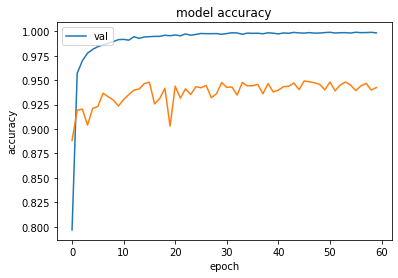

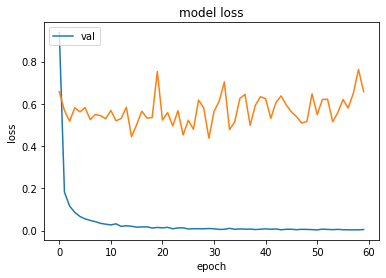

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 2s 17ms/step - loss: 0.6572 - accuracy: 0.9425 - auc: 0.9813 - recall: 0.9412
Test loss:0.6571820378303528
Test accuracy:0.9425133466720581
Test Recall: 0.9411764740943909
Test AUC: 0.9812990427017212


# Train dataset 2 test = val

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 32)      1760        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 32)     128         ['conv1d_3[0][0]']               
 rmalization)                                                                               

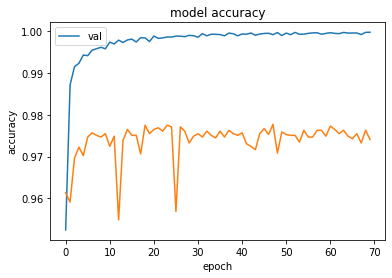

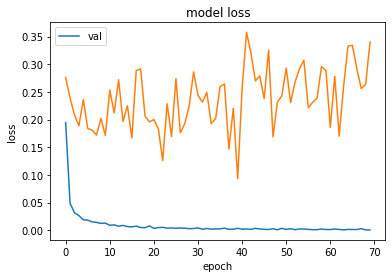

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 2s 16ms/step - loss: 0.3399 - accuracy: 0.9741 - auc: 0.9886 - recall: 0.9737
Test loss:0.33987554907798767
Test accuracy:0.9740680456161499
Test Recall: 0.9736629128456116
Test AUC: 0.9886150360107422


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


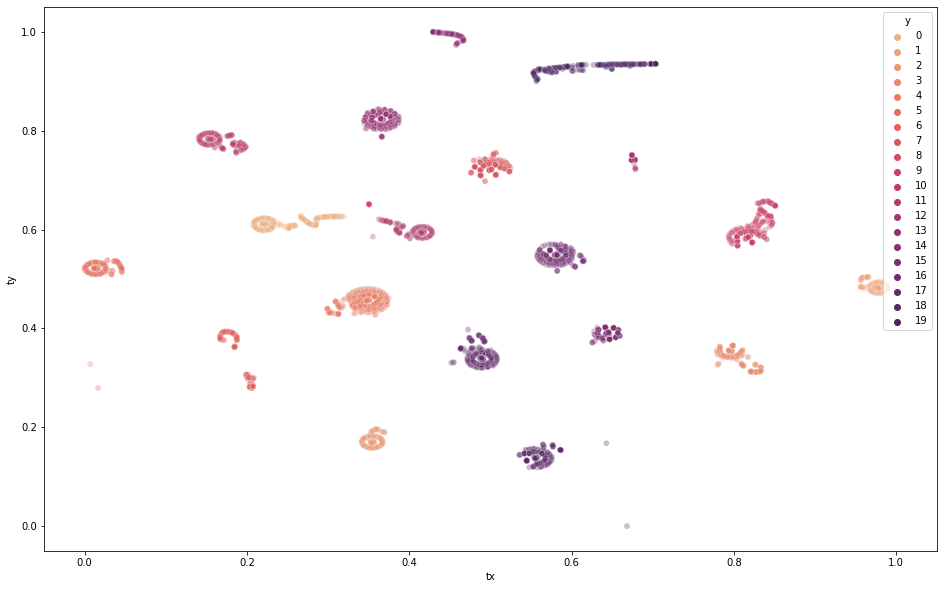

In [ ]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
features = model.predict(X_test)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features)
import pandas as pd
def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))

    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)
tx = list(tx)
ty = list(ty)

data = {'tx':tx,
        'ty':ty}
df = pd.DataFrame(data)
df['y'] = y_classes
# fig = plt.figure()

# ax = fig.add_subplot(111)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tx", y="ty",
    hue="y",
    palette=sns.color_palette("flare", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)

#Train Test = val Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 32)      1760        ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 32)     128         ['conv1d_6[0][0]']               
 rmalization)                                          

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 32)      1760        ['permute_3[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 32)     128         ['conv1d_9[0][0]']               
 rmalization)                                                                               

In [ ]:
get_test_performance(model, X_test, test_label)